<a href="https://colab.research.google.com/github/Jakub-Svoboda/VDT-predictive-NN/blob/main/vdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [74]:
import tensorflow as tf
import numpy as np
import csv
import os
import glob
import pandas as pd
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Dataset

In [75]:
# Remove sample_data folder which is added to colab automatically
!rm -rf sample_data

# Merge dataset from 90-days files
if not os.path.exists("dataset/data_merged.csv"):
  os.chdir("dataset")

  extension = 'csv'
  all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
  all_filenames = sorted(all_filenames)

  # Combine all files in the list
  combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
  # Export to csv
  combined_csv.to_csv( "data_merged.csv", index=False, encoding='utf-8-sig')
  os.chdir("..")

##Filtering

Show missing values and improper sampling

In [76]:
df = pd.read_csv(os.path.join("dataset", "data_merged.csv"))
lastDate = datetime.datetime.strptime("2017-11-01T01:00:00Z", '%Y-%m-%dT%H:%M:%SZ')
problemsCount = 0

# Go through data line by line
for index, row in df.iterrows():
  # The gap between two data points should be 5 minutes (300 sec)
  date = datetime.datetime.strptime(row['_time'], '%Y-%m-%dT%H:%M:%SZ')
  delta = (date - lastDate).total_seconds()
  lastDate = date
  if delta != 300: # Sampling should be done at 5min intervals == 300 sec
    problemsCount+=1
    #print("Delta:", delta, "     \t\t at time",date)

print(f'Processed {df.shape[0]} lines, found a total of', problemsCount, "problematic values/gaps.")

Processed 225510 lines, found a total of 440 problematic values/gaps.


In [77]:
# Keep only these columns
df = df.filter(items=['CHSK', 'N_NO3', 'NL', 'pH', 'q', 'Teplota', 'Toxicita', 'Vodivost', '_time'])

# Some of the data is sampled with different time rate. Eg in 2019 there was a period where the sampling period was 4 minutes. 
# For this reason, we filter values which were not sampled at the 5min interval (their time stamp does not end with 05 or 00).
df = df[(df['_time'].str.endswith(('5:00Z', '0:00Z')))]

In [78]:
lastDate = datetime.datetime.strptime("2017-11-01T01:00:00Z", '%Y-%m-%dT%H:%M:%SZ')
problemsCount = 0

# Go through data line by line
for index, row in df.iterrows():
  # The gap between two data points should be 5 minutes (300 sec)
  date = datetime.datetime.strptime(row['_time'], '%Y-%m-%dT%H:%M:%SZ')
  delta = (date - lastDate).total_seconds()
  lastDate = date
  if(delta != 300):
    problemsCount+=1
    print("Delta:", delta, "     \t\t at time",date)

print(f'Processed {df.shape[0]} lines, found a total of', problemsCount, "problematic values/gaps.")
df.shape

Delta: 2400.0      		 at time 2017-11-02 13:55:00
Delta: 1500.0      		 at time 2017-11-09 10:50:00
Delta: 5100.0      		 at time 2017-11-09 12:15:00
Delta: 2700.0      		 at time 2017-11-14 11:55:00
Delta: 4800.0      		 at time 2017-11-22 12:15:00
Delta: 600.0      		 at time 2017-11-28 18:00:00
Delta: 17700.0      		 at time 2017-11-29 05:30:00
Delta: 900.0      		 at time 2017-11-29 13:00:00
Delta: 8700.0      		 at time 2017-11-29 15:35:00
Delta: 3600.0      		 at time 2017-11-30 11:05:00
Delta: 3600.0      		 at time 2017-12-05 08:55:00
Delta: 900.0      		 at time 2017-12-11 09:30:00
Delta: 3600.0      		 at time 2017-12-13 10:50:00
Delta: 3600.0      		 at time 2017-12-21 10:55:00
Delta: 3000.0      		 at time 2017-12-28 09:40:00
Delta: 1200.0      		 at time 2018-01-05 08:25:00
Delta: 3600.0      		 at time 2018-01-05 11:00:00
Delta: 2700.0      		 at time 2018-01-10 11:25:00
Delta: 900.0      		 at time 2018-01-15 12:40:00
Delta: 13200.0      		 at time 2018-01-16 14:10:00
De

(225297, 9)

In [79]:
# Add a column of unix time (int), which is derived from _time
df['unixTime'] = [int(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=datetime.timezone.utc).timestamp()) for x in df['_time']]

t = df.head(1).iloc[0]['unixTime']
t2 = df.tail(1).iloc[0]['unixTime']
#print("Time beginning:", t, "- end:", t2)

#print(df.shape)

times = df['unixTime']
#print(df.head(10))

df.to_csv( "filt.csv", index=False, encoding='utf-8-sig')
count = 0

df2 = pd.DataFrame(columns = ['CHSK', 'NL', 'N_NO3', 'Teplota', 'Toxicita', 'Vodivost', '_time', 'pH', 'q', 'unixTime'])

for index, i in enumerate(range(1509498300, 1577836800+300, 300)):
  if i not in times.values:
    #print("Missing:", index, i)
    df2 = df2.append({'CHSK': None, 'NL': None, 'N_NO3': None, 'Teplota': None, 'Toxicita': None, 'Vodivost': None, '_time': None, 'pH': None, 'q': None, 'unixTime': i}, ignore_index = True)
    count += 1

print("Filled in a total of:", count, "missing data.")

# Append new values to the dataframe
df = df.append(df2, ignore_index = True)    

# Sort df
df = df.sort_values('unixTime')

Filled in a total of: 2499 missing data.


In [80]:
df.to_csv( "filt2.csv", index=False, encoding='utf-8-sig')

Calculate new _time items for the filled in data. For each item in dataframe, if the _time is missing, fill in previous _time + 5 minutes.

In [81]:
df = pd.read_csv("filt2.csv")

# Fill in the _time values from previous entry
for index, row in df.iterrows():
  if pd.isnull(df['_time'].iloc[index]):
    #print(index-1, df.at[index-1, '_time'])
    newDate = datetime.datetime.strptime(df.at[index-1, '_time'], '%Y-%m-%dT%H:%M:%SZ') + datetime.timedelta(minutes=5)
    #print(newDate.strftime("%Y-%m-%dT%H:%M:%SZ"))
    df.at[index,'_time'] = newDate.strftime("%Y-%m-%dT%H:%M:%SZ")
    #print(index, df.at[index,'_time'])
    #print('------')
    
print("Inserted", count, "_time dates. DF shape:", df.shape)


Inserted 2499 _time dates. DF shape: (227796, 10)


Interpolate missing data with 3th order polynomial interpolation

In [82]:
df = df.interpolate(method='polynomial', order=3)
print(df.iloc[2417])

CHSK                     486.805
N_NO3                    1.12867
NL                       187.699
pH                       7.92102
q                        2.80808
Teplota                  17.1796
Toxicita                0.412949
Vodivost                 1207.83
_time       2017-11-09T10:30:00Z
unixTime             1.51022e+09
Name: 2417, dtype: object


##Dataset inspection

In [83]:
df.head()

,CHSK,N_NO3,NL,pH,q,Teplota,Toxicita,Vodivost,_time,unixTime
0,520.51,0.68,226.69,7.1,1.871,18.8,0.48,1100.0,2017-11-01T01:05:00Z,1.509498e+09
1,521.18,0.66,227.46,7.1,1.866,18.8,0.49,1101.0,2017-11-01T01:10:00Z,1.509499e+09
2,520.74,0.67,227.10,7.2,1.845,18.8,0.45,1102.0,2017-11-01T01:15:00Z,1.509499e+09
3,521.36,0.65,227.68,7.1,1.776,18.8,0.49,1109.0,2017-11-01T01:20:00Z,1.509499e+09
4,520.89,0.65,227.60,7.2,1.800,18.9,0.45,1113.0,2017-11-01T01:25:00Z,1.509500e+09


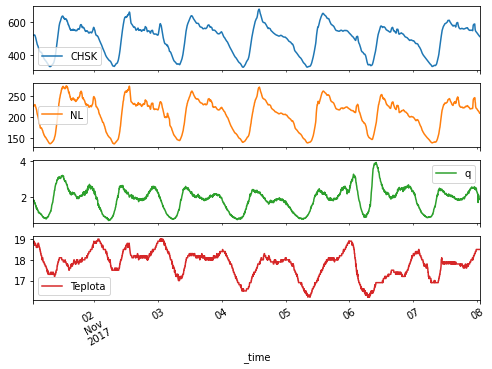

In [84]:
fiveMinsInWeek = 2016
date_time = pd.to_datetime(df['_time'], format='%Y-%m-%dT%H:%M:%SZ')
plot_cols = ['CHSK', 'NL', 'q', 'Teplota']

plot_features = df[plot_cols][0:fiveMinsInWeek]
plot_features.index = date_time.iloc[:fiveMinsInWeek]
_ = plot_features.plot(subplots=True)


In [85]:
df.describe().transpose()
# Teplota   max 1.271387e+02    = 127C
# N_NO3     min -1.828027e+00   = -1.8

,count,mean,std,min,25%,50%,75%,max
CHSK,227796.0,5.148296e+02,1.102134e+02,2.463800e+02,4.364100e+02,5.251800e+02,5.818300e+02,1.778800e+03
N_NO3,227796.0,1.665879e+00,6.615546e-01,-1.828027e+00,1.190000e+00,1.620000e+00,2.100000e+00,1.072049e+01
NL,227796.0,2.070380e+02,5.291201e+01,6.790266e+01,1.737800e+02,2.065800e+02,2.311900e+02,1.128390e+03
pH,227796.0,7.402966e+00,7.210242e-01,-2.222755e+01,7.100000e+00,7.400000e+00,7.700000e+00,1.240448e+01
q,227796.0,1.998345e+00,1.025974e+00,6.380000e-01,1.452000e+00,2.015000e+00,2.307000e+00,2.628500e+01
Teplota,227796.0,1.786023e+01,3.333545e+00,0.000000e+00,1.590000e+01,1.770000e+01,1.970000e+01,1.271387e+02
Toxicita,227796.0,4.879889e-01,2.428197e-01,-4.989373e+00,4.000000e-01,4.500000e-01,5.200000e-01,1.289000e+01
Vodivost,227796.0,1.127895e+03,2.073007e+02,0.000000e+00,1.074000e+03,1.145000e+03,1.208000e+03,4.054000e+03
unixTime,227796.0,1.543668e+09,1.972776e+07,1.509498e+09,1.526583e+09,1.543668e+09,1.560752e+09,1.577837e+09


# Feature Engineering


First add a column representing the time of the day.


In [86]:
secondsPerDay = 24*60*60
secondsPerYear = (365.2425)*secondsPerDay 

# Get seconds from date
timestamp_s = date_time.map(datetime.datetime.timestamp)

# Add columns to the dataframe
df['Day Sin'] = np.sin(timestamp_s * (2 * np.pi / secondsPerDay))
df['Day Cos'] = np.cos(timestamp_s * (2 * np.pi / secondsPerDay))
df['Year Sin'] = np.sin(timestamp_s * (2 * np.pi / secondsPerYear))
df['Year Cos'] = np.cos(timestamp_s * (2 * np.pi / secondsPerYear))

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CHSK,227796.0,5.148296e+02,1.102134e+02,2.463800e+02,4.364100e+02,5.251800e+02,5.818300e+02,1.778800e+03
N_NO3,227796.0,1.665879e+00,6.615546e-01,-1.828027e+00,1.190000e+00,1.620000e+00,2.100000e+00,1.072049e+01
NL,227796.0,2.070380e+02,5.291201e+01,6.790266e+01,1.737800e+02,2.065800e+02,2.311900e+02,1.128390e+03
pH,227796.0,7.402966e+00,7.210242e-01,-2.222755e+01,7.100000e+00,7.400000e+00,7.700000e+00,1.240448e+01
q,227796.0,1.998345e+00,1.025974e+00,6.380000e-01,1.452000e+00,2.015000e+00,2.307000e+00,2.628500e+01
Teplota,227796.0,1.786023e+01,3.333545e+00,0.000000e+00,1.590000e+01,1.770000e+01,1.970000e+01,1.271387e+02
Toxicita,227796.0,4.879889e-01,2.428197e-01,-4.989373e+00,4.000000e-01,4.500000e-01,5.200000e-01,1.289000e+01
Vodivost,227796.0,1.127895e+03,2.073007e+02,0.000000e+00,1.074000e+03,1.145000e+03,1.208000e+03,4.054000e+03
unixTime,227796.0,1.543668e+09,1.972776e+07,1.509498e+09,1.526583e+09,1.543668e+09,1.560752e+09,1.577837e+09
Day Sin,227796.0,-7.424154e-06,7.071260e-01,-1.000000e+00,-7.071068e-01,-5.639925e-14,7.071068e-01,1.000000e+00


In [87]:
# Remove the helper columns (unixtime, daytime, _time)
df = df.filter(items=['CHSK', 'N_NO3', 'NL', 'pH', 'q', 'Teplota', 'Toxicita', 'Vodivost', 'Day Sin', 'Day Cos', 'Year Sin', 'Year Cos', ])
df.tail()

,CHSK,N_NO3,NL,pH,q,Teplota,Toxicita,Vodivost,Day Sin,Day Cos,Year Sin,Year Cos
227791,844.36,0.00,413.77,7.1,1.553,17.1,0.28,1153.0,-8.715574e-02,0.996195,-0.002389,0.999997
227792,836.58,0.00,403.74,7.0,1.588,17.1,0.29,1155.0,-6.540313e-02,0.997859,-0.002330,0.999997
227793,827.98,0.19,399.68,7.0,1.576,17.1,0.30,1158.0,-4.361939e-02,0.999048,-0.002270,0.999997
227794,818.24,0.16,393.00,7.0,1.606,17.1,0.32,1162.0,-2.181489e-02,0.999762,-0.002210,0.999998
227795,807.11,0.19,385.32,7.0,1.539,17.1,0.32,1166.0,-7.670342e-12,1.000000,-0.002150,0.999998


Text(0.5, 1.0, 'Time of day signal')

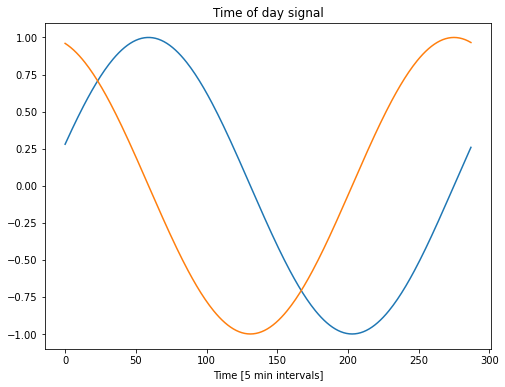

In [88]:
plt.plot(np.array(df['Day Sin'])[:12*24])
plt.plot(np.array(df['Day Cos'])[:12*24])
plt.xlabel('Time [5 min intervals]')
plt.title('Time of day signal')

##Split


In [89]:
columnIndices = {name: i for i, name in enumerate(df.columns)}

# 80% train, 10% val, 10% test
n = len(df)
trainDf   = df[0:int(n*0.8)]
valDf     = df[int(n*0.8):int(n*0.9)]
testDf    = df[int(n*0.9):]

numFeatures = df.shape[1]
df.shape

(227796, 12)

##Normalization

In [90]:
# Normalization = substraction of the mean and dividing by the standard deviation
trainMean = trainDf.mean()
trainStd = trainDf.std()

trainDf = (trainDf - trainMean) / trainStd
valDf = (valDf - trainMean) / trainStd
testDf = (testDf - trainMean) / trainStd

#Windowing

In [91]:
class WindowGenerator():
  def __init__(self, inputWidth, labelWidth, shift,
               trainDf=trainDf, valDf=valDf, testDf=testDf,
               labelColumns=None):
    # Store the raw data.
    self.trainDf = trainDf
    self.valDf = valDf
    self.testDf = testDf

    # Work out the label column indices.
    self.labelColumns = labelColumns
    if labelColumns is not None:
      self.labelColumnsIndices = {name: i for i, name in enumerate(labelColumns)}
    self.columnIndices = {name: i for i, name in enumerate(trainDf.columns)}

    # Work out the window parameters.
    self.inputWidth = inputWidth
    self.labelWidth = labelWidth
    self.shift = shift

    self.totalWindowSize = inputWidth + shift

    self.inputSlice = slice(0, inputWidth)
    self.inputIndices = np.arange(self.totalWindowSize)[self.inputSlice]

    self.labelStart = self.totalWindowSize - self.labelWidth
    self.labelsSlice = slice(self.labelStart, None)
    self.labelIndices = np.arange(self.totalWindowSize)[self.labelsSlice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.totalWindowSize}',
        f'Input indices: {self.inputIndices}',
        f'Label indices: {self.labelIndices}',
        f'Label column name(s): {self.labelColumns}'])
    
  # Splits window into a inputs and labels  
  def splitWindow(self, features):
    inputs = features[:, self.inputSlice, :]
    labels = features[:, self.labelsSlice, :]
    if self.labelColumns is not None:
      labels = tf.stack(
          [labels[:, :, self.columnIndices[name]] for name in self.labelColumns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.inputWidth, None])
    labels.set_shape([None, self.labelWidth, None])

    return inputs, labels 

  def plot(self, model=None, plotCol='CHSK', maxSubplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plotColIndex = self.columnIndices[plotCol]
    maxN = min(maxSubplots, len(inputs))
    for n in range(maxN):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plotCol} [normed]')
      plt.plot(self.inputIndices, inputs[n, :, plotColIndex], label='Inputs', marker='.', zorder=-10)

      if self.labelColumns:
        labelColIndex = self.labelColumnsIndices.get(plotCol, None)
      else:
        labelColIndex = plotColIndex

      if labelColIndex is None:
        continue

      plt.scatter(self.labelIndices, labels[n, :, labelColIndex], edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.labelIndices, predictions[n, :, labelColIndex], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]') 

  def makeDataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.totalWindowSize,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.splitWindow)
    return ds

  @property
  def train(self):
    return self.makeDataset(self.trainDf)

  @property
  def val(self):
    return self.makeDataset(self.valDf)

  @property
  def test(self):
    return self.makeDataset(self.testDf)



2016
All shapes are: (batch, time, features)
Window shape: (3, 2016, 12)
Inputs shape: (3, 1728, 12)
labels shape: (3, 288, 1)


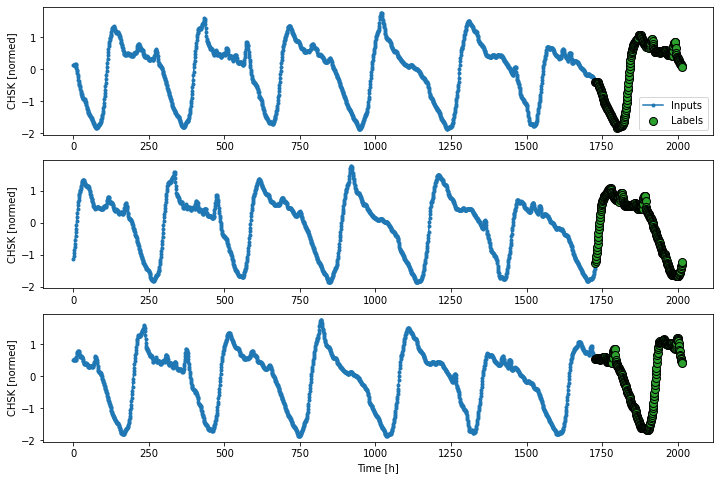

In [92]:
w2 = WindowGenerator(inputWidth=288*6, labelWidth=288, shift=288, labelColumns=['CHSK'])

print(w2.totalWindowSize)

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(trainDf[:w2.totalWindowSize]),
                           np.array(trainDf[100:100+w2.totalWindowSize]),
                           np.array(trainDf[200:200+w2.totalWindowSize])])


example_inputs, example_labels = w2.splitWindow(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

w2.example = example_inputs, example_labels
w2.plot()

In [93]:
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.example = example

In [94]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 1728, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 288, 1), dtype=tf.float32, name=None))

#Single Step Models

In [95]:
single_step_window = WindowGenerator(
    inputWidth=1, labelWidth=1, shift=1,
    labelColumns=['CHSK'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CHSK']

In [96]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 12)
Labels shape (batch, time, features): (32, 1, 1)


##Baseline

In [97]:
class Baseline(tf.keras.Model):
  def __init__(self, labelIndex=None):
    super().__init__()
    self.labelIndex = labelIndex

  def call(self, inputs):
    if self.labelIndex is None:
      return inputs
    result = inputs[:, :, self.labelIndex]
    return result[:, :, tf.newaxis]

Initialize and evaluate

In [98]:
baseline = Baseline(labelIndex=columnIndices['CHSK'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

712/712 [==============================] - 2s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0310


In [99]:
wide_window = WindowGenerator(
    inputWidth=24, labelWidth=24, shift=1,
    labelColumns=['CHSK'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['CHSK']

In [100]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


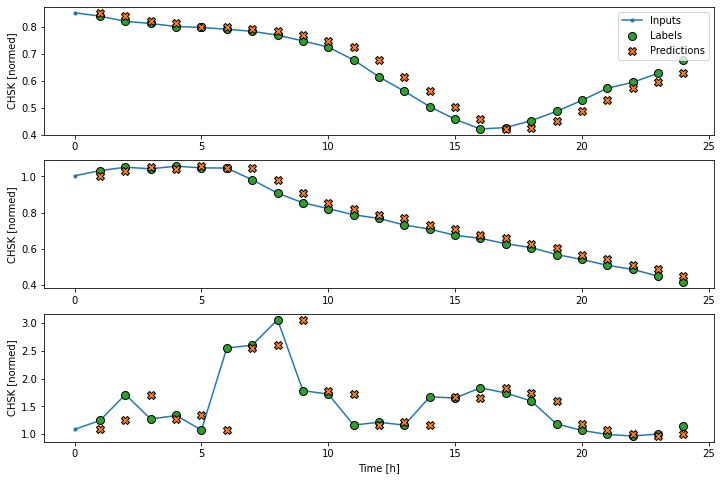

In [101]:
wide_window.plot(baseline)

##Linear Model

In [102]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


In [103]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [104]:
%%script false --no-raise-error

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [105]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


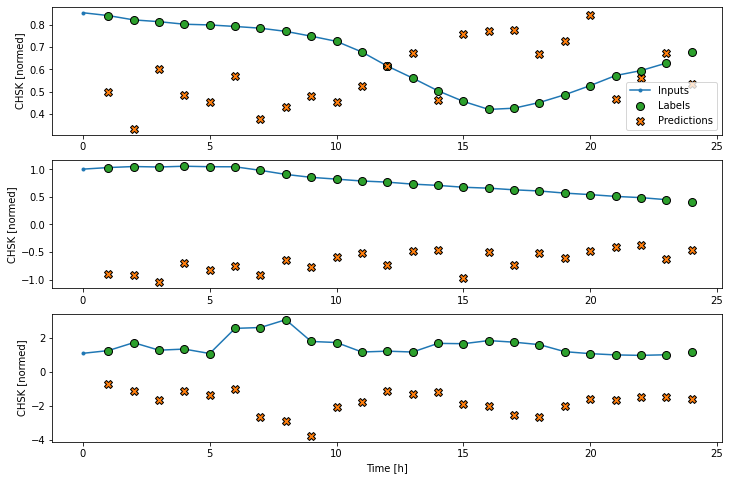

In [106]:
wide_window.plot(linear)

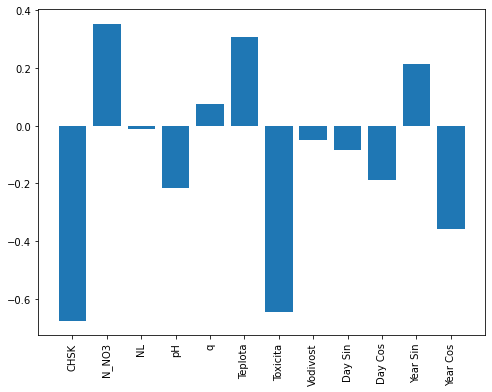

In [107]:
plt.bar(x = range(len(trainDf.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(trainDf.columns)))
_ = axis.set_xticklabels(trainDf.columns, rotation=90)

## Dense

In [108]:
%%script false --no-raise-error

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [109]:
%%script false --no-raise-error

wide_window.plot(dense)

##Multi step dense

In [110]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    inputWidth=CONV_WIDTH,
    labelWidth=1,
    shift=1,
    labelColumns=['CHSK'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['CHSK']

Text(0.5, 1.0, 'Given 15min as input, predict 5min into the future.')

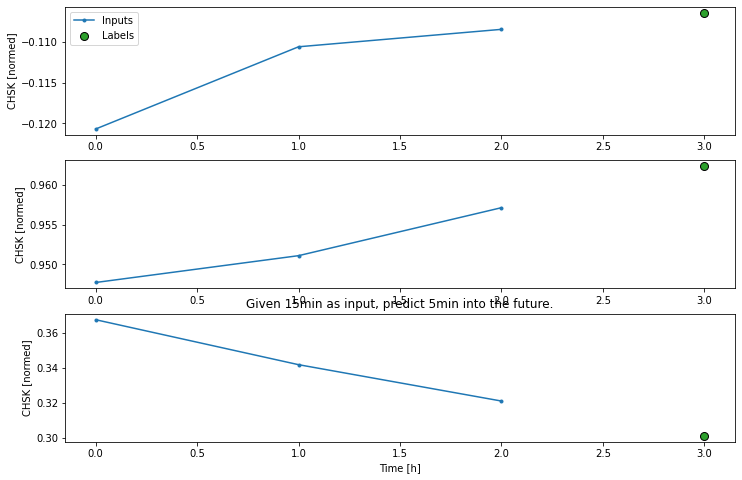

In [111]:
conv_window.plot()
plt.title("Given 15min as input, predict 5min into the future.")

In [112]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [113]:
%%script false --no-raise-error

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

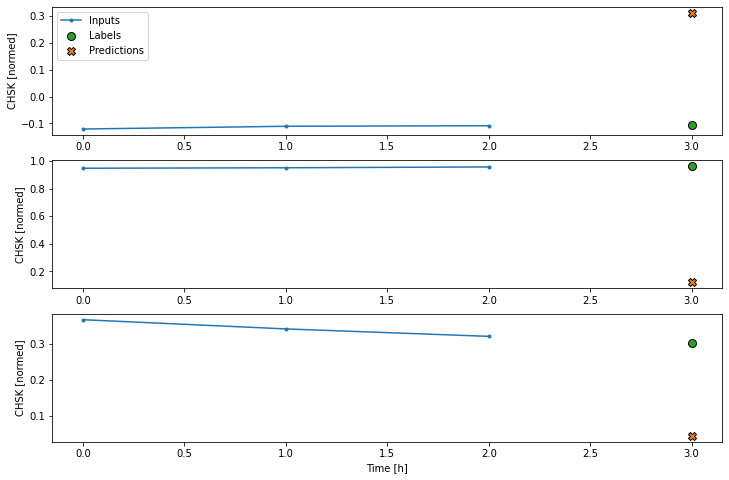

In [114]:
conv_window.plot(multi_step_dense)

##Convolutional NN


In [115]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 12)
Output shape: (32, 1, 1)


In [116]:
%%script false --no-raise-error

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [117]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    inputWidth=INPUT_WIDTH,
    labelWidth=LABEL_WIDTH,
    shift=1,
    labelColumns=['CHSK'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['CHSK']

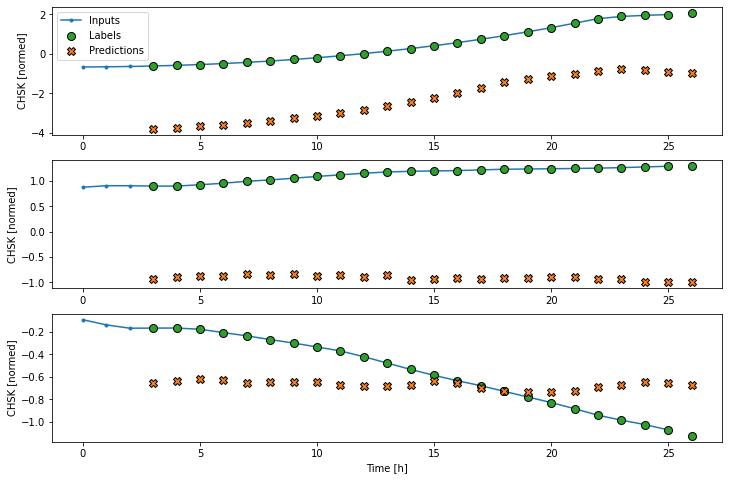

In [118]:
wide_conv_window.plot(conv_model)

##Recurrent NN

In [119]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)


In [120]:
%%script false --no-raise-error

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

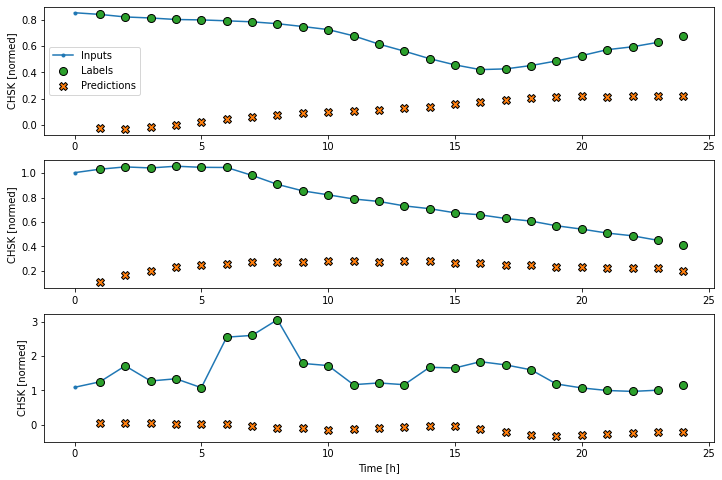

In [121]:
wide_window.plot(lstm_model)

## Performance

In [123]:
%%script false --no-raise-error

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [CHSK, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [124]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0310


# Multi-step models


Total window size: 1152
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

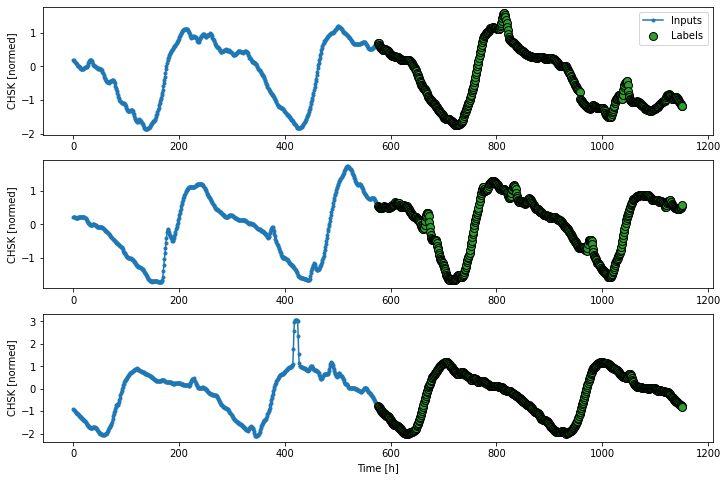

In [128]:
OUT_STEPS = 24*12*2
multi_window = WindowGenerator(inputWidth=24*12*2,
                               labelWidth=OUT_STEPS,
                               shift=OUT_STEPS,
                               labelColumns=['CHSK'])

multi_window.plot()
multi_window

##Baseline

676/676 [==============================] - 3s 5ms/step - loss: 2.3663 - mean_absolute_error: 1.1763


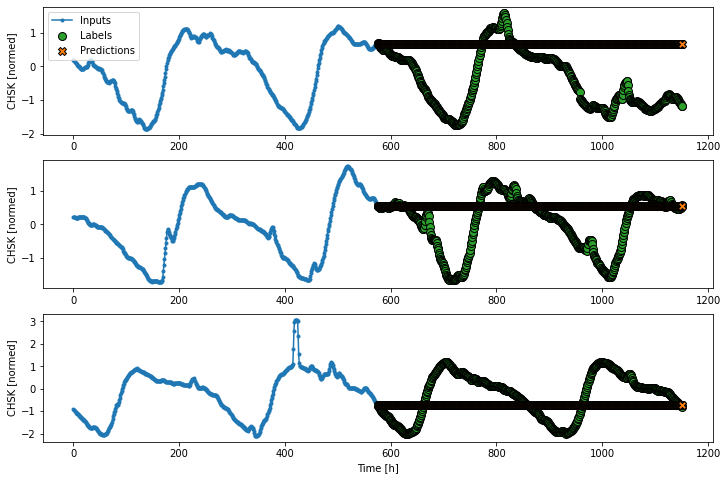

In [129]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

676/676 [==============================] - 3s 5ms/step - loss: 2.3529 - mean_absolute_error: 1.1541


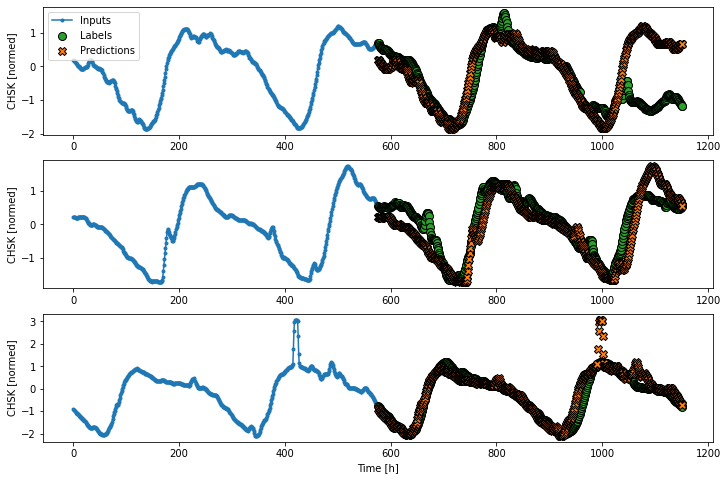

In [130]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single shot models


###Linear

676/676 [==============================] - 3s 5ms/step - loss: 0.8184 - mean_absolute_error: 0.6768


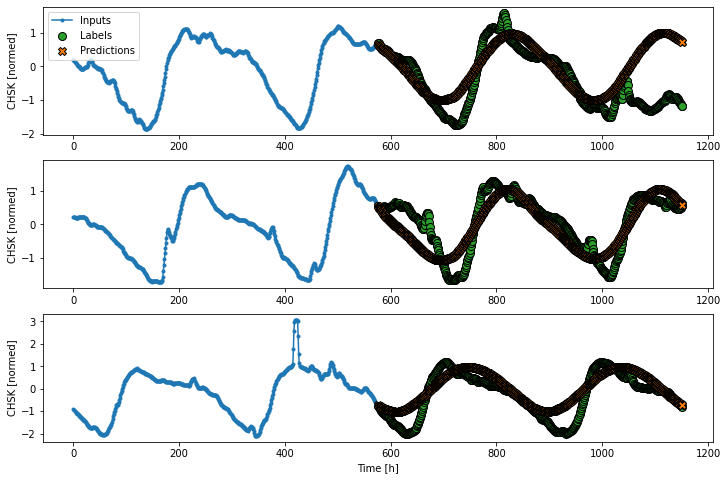

In [131]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numFeatures])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

###Dense


676/676 [==============================] - 4s 5ms/step - loss: 0.6195 - mean_absolute_error: 0.5779


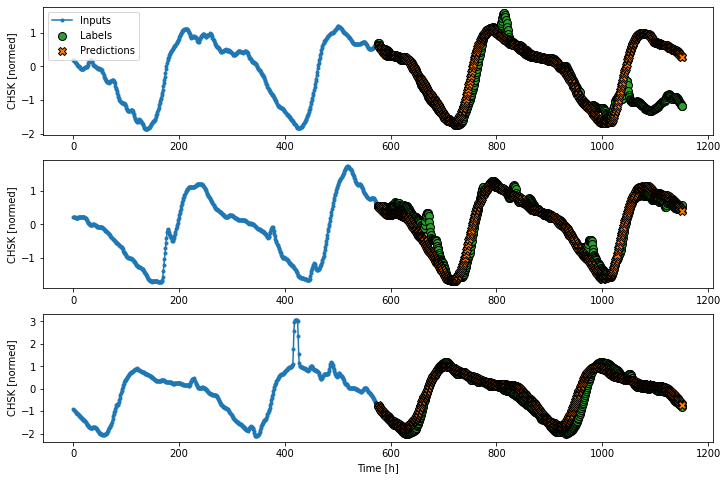

In [132]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numFeatures])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

676/676 [==============================] - 4s 5ms/step - loss: 0.6791 - mean_absolute_error: 0.5870


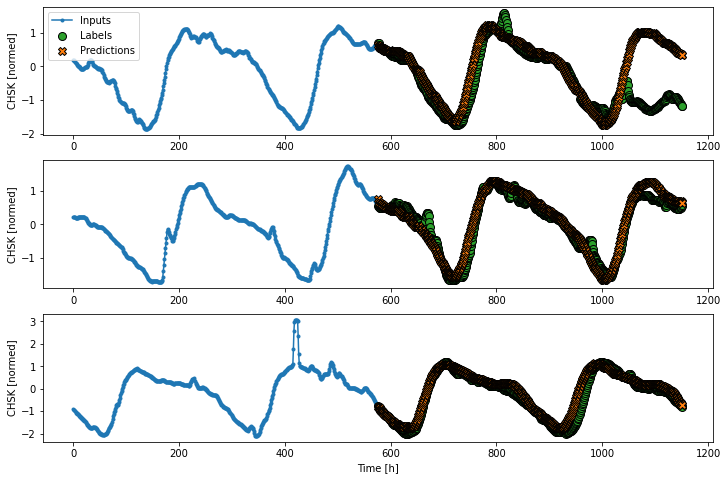

In [133]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numFeatures])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

###RNN

676/676 [==============================] - 8s 12ms/step - loss: 0.6834 - mean_absolute_error: 0.5814


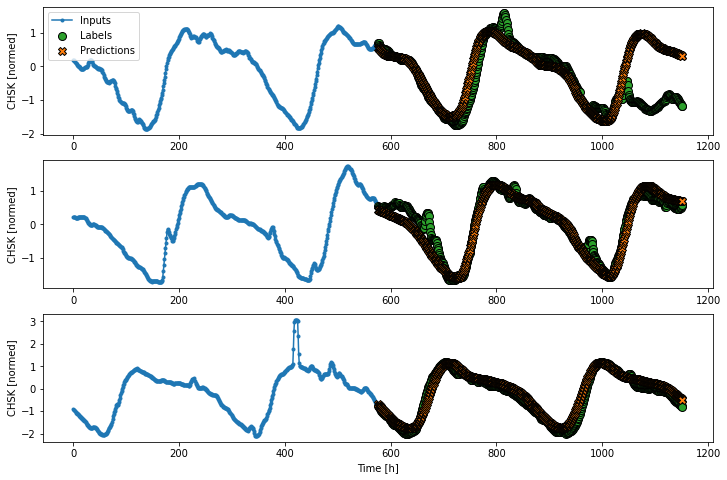

In [134]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numFeatures])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

###Autoregressive NN


In [135]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(numFeatures)

In [136]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [137]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [138]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

In [139]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [140]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 576, 12)


In [141]:
%%script false --no-raise-error

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

##Performance

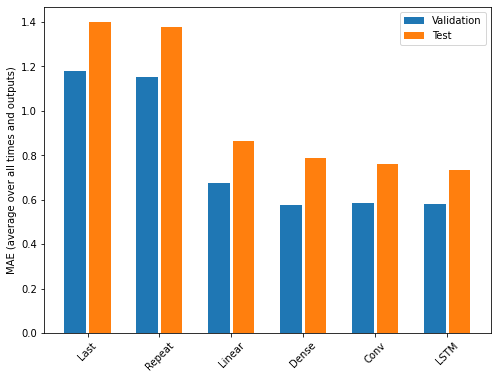

In [145]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [146]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

'''
2 day window, 2 day prediction, no weekend indicators
Last    : 1.3974
Repeat  : 1.3772
Linear  : 0.8641
Dense   : 0.7892
Conv    : 0.7618
LSTM    : 0.7354
'''  

Last    : 1.3974
Repeat  : 1.3772
Linear  : 0.8641
Dense   : 0.7892
Conv    : 0.7618
LSTM    : 0.7354
